In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
import pandas as pd
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae, rmse  # noqa
from darts.models import (
    LinearRegressionModel,
    NaiveMovingAverage,
    ExponentialSmoothing,  # noqa: F401
    Prophet,  # noqa: F401
    CatBoostModel,
)  # noqa
import matplotlib.pyplot as plt
from tasks_support_system_ai.data.reader import read_data
import seaborn as sns
from tasks_support_system_ai.data.reader import DataFrames

In [27]:
import logging

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [28]:
df = read_data(DataFrames.TS_DAILY)

In [29]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


In [5]:
tree = read_data(DataFrames.TS_HIERARCHY_PARSED)

Нас интересуют корневые очереди с ненулевой нагрузкой

In [6]:
top_level_tree = tree[(tree["level"] == 1) & (tree["full_load"] != 0)]
top_level_tree.sort_values("full_load", ascending=False)

,queueId,level,immediateDescendants,allDescendants,full_load
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146
481,1866,1,"[4307, 4352, 4587, 4667, 4682, 762, 100081, 10...","[762, 1866, 2382, 2733, 3536, 3576, 3617, 3836...",1470013
285,742,1,"[39, 98, 118, 4322, 4412, 2458, 2610, 2921, 3093]","[9, 13, 26, 39, 83, 98, 101, 110, 116, 118, 37...",1387729
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019
163,4447,1,"[57, 4457, 4612, 4617, 100254, 100261, 4793, 1...","[57, 382, 1162, 1741, 1881, 1887, 1981, 2007, ...",1121534
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237
41,4147,1,"[7, 14, 4442, 100329, 100034, 100092, 100105, ...","[7, 14, 2544, 3045, 3086, 3095, 3551, 3884, 41...",681754


## prediction (no external features)

In [7]:
from darts.utils.timeseries_generation import holidays_timeseries
from darts.models import RegressionModel

Будем предсказывать 19 верхнеуровневых очередей и на них валидировать модели

In [8]:
top_level_queues = list(
    top_level_tree[top_level_tree["full_load"] >= 10_000]["queueId"].values
)
len(top_level_queues), top_level_queues

(19,
 [10,
  34,
  40,
  4147,
  4167,
  115,
  4397,
  4447,
  742,
  1866,
  1871,
  100273,
  2002,
  100322,
  2641,
  2709,
  2922,
  3474,
  3936])

In [61]:
queue_id = 1871
n_predict = 100
output_chunk_length = 100

In [62]:
from tasks_support_system_ai.services.ts.predictor import get_df_slice


df_slice = get_df_slice(queue_id)
ts = TimeSeries.from_dataframe(
    df_slice,
    value_cols="new_tickets",
    fill_missing_dates=True,
    fillna_value=0,
    freq="D",
)
ts_train = ts[:-n_predict]
ts_val = ts[-n_predict:]

In [63]:
model = RegressionModel(
    lags=10,
    output_chunk_length=output_chunk_length,
)
model.fit(
    ts_train
)
model.backtest(ts_train)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


13.196546222558997

In [64]:
cat_model = CatBoostModel(
    lags=10,
    output_chunk_length=output_chunk_length,
)
cat_model.fit(
    ts_train
)
cat_model.backtest(ts_train, retrain=False)

5.528995231166326

<Axes: xlabel='date'>

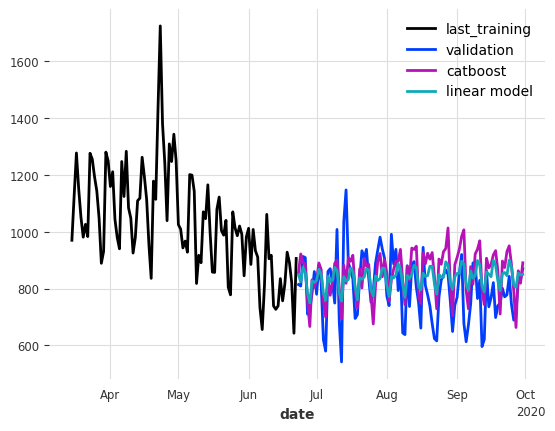

In [65]:
ts_train[-100:].plot(label='last_training')
ts_val.plot(label='validation')
cat_model.predict(100).plot(label='catboost')
model.predict(100).plot(label='linear model')

## Prediction with external features (WIP)

### past covariates
- full load

### future covariates
- weekends
- holidays

In [ ]:

df_total = df.groupby("date")[["new_tickets"]].sum()
past_covariates = TimeSeries.from_dataframe(
    df_total,
    value_cols="new_tickets",
    fill_missing_dates=True,
    freq="D",
).with_columns_renamed("new_tickets", "all_new_tickets")
holidays = holidays_timeseries(
    time_index=past_covariates,
    country_code="RU",
    add_length=n_predict,
)


def create_weekend_timeseries(time_index, add_length=0):
    # Create full date range including prediction period
    full_range = pd.date_range(
        start=time_index[0],
        end=time_index[-1] + pd.Timedelta(days=add_length),
        freq=time_index.freq,
    )

    # Create weekend indicator (1 for weekend, 0 for weekday)
    is_weekend = [1 if x.weekday() >= 5 else 0 for x in full_range]

    # Create TimeSeries
    weekend_series = TimeSeries.from_times_and_values(
        times=full_range, values=is_weekend
    ).with_columns_renamed("0", "weekends")

    return weekend_series


weekends = create_weekend_timeseries(
    time_index=past_covariates.time_index, add_length=n_predict
)
future_covariates = holidays.concatenate(weekends, axis=1)

In [13]:
past_covariates

<TimeSeries (DataArray) (date: 1369, component: 1, sample: 1)> Size: 11kB
array([[[ 1648.]],

       [[ 2556.]],

       [[ 3055.]],

       ...,

       [[24743.]],

       [[27645.]],

       [[31039.]]])
Coordinates:
  * date       (date) datetime64[ns] 11kB 2017-01-01 2017-01-02 ... 2020-09-30
  * component  (component) object 8B 'all_new_tickets'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [14]:
future_covariates

<TimeSeries (DataArray) (time: 1469, component: 2, sample: 1)> Size: 24kB
array([[[1.],
        [1.]],

       [[1.],
        [0.]],

       [[1.],
        [0.]],

       ...,

       [[1.],
        [0.]],

       [[1.],
        [0.]],

       [[1.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 12kB 2017-01-01 2017-01-02 ... 2021-01-08
  * component  (component) object 16B 'holidays' 'weekends'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [15]:
queue_id = 1871
df_slice = get_df_slice(queue_id)
ts = TimeSeries.from_dataframe(
    df_slice,
    value_cols="new_tickets",
    fill_missing_dates=True,
    fillna_value=0,
    freq="D",
)

In [30]:
ts_train = ts[:-n_predict]
ts_val = ts[n_predict:]
model = RegressionModel(
    lags=10,
    lags_past_covariates=5,
    lags_future_covariates=(5, 5),
    output_chunk_length=n_predict,
)
model.fit(
    ts_train, past_covariates=past_covariates, future_covariates=future_covariates
)

RegressionModel(lags=10, lags_past_covariates=5, lags_future_covariates=(5, 5), output_chunk_length=100, output_chunk_shift=0, add_encoders=None, model=None, multi_models=True, use_static_covariates=True)

In [31]:
model.predict(
    n_predict,
    ts_val,
    past_covariates=past_covariates,
    future_covariates=future_covariates,
)

<TimeSeries (DataArray) (date: 100, component: 1, sample: 1)> Size: 800B
array([[[1114.1003331 ]],

       [[1035.79955759]],

       [[ 883.48497274]],

       [[ 902.0403026 ]],

       [[1133.1807856 ]],

       [[1196.11939791]],

       [[1243.80628893]],

       [[1216.06620956]],

       [[1109.44842379]],

       [[ 961.87001352]],

...

       [[1626.3441978 ]],

       [[1604.50894012]],

       [[1469.66771117]],

       [[1259.81770432]],

       [[1211.01034292]],

       [[1446.27690727]],

       [[1484.82547815]],

       [[1544.91463888]],

       [[1535.68211297]],

       [[1420.37917261]]])
Coordinates:
  * date       (date) datetime64[ns] 800B 2020-10-01 2020-10-02 ... 2021-01-08
  * component  (component) object 8B 'new_tickets'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [32]:
model.backtest(ts_train,
                    stride=10,
                    show_warnings=False,
                    past_covariates=past_covariates,
                    future_covariates=future_covariates,)

12.203344384562099

In [ ]:
from darts.metrics import mape
from darts.models import RegressionModel, RandomForest, LightGBMModel
import pandas as pd
import numpy as np

def evaluate_model(model, ts_train, ts_val, past_covariates=None, future_covariates=None):
    """Evaluate model with different configurations."""
    if past_covariates is not None and future_covariates is not None:
        pred = model.predict(
            n=len(ts_val),
            series=ts_train,
            past_covariates=past_covariates,
            future_covariates=future_covariates
        )
    else:
        pred = model.predict(n=len(ts_val), series=ts_train)

    return mape(ts_val, pred)

def test_models():
    # 1. Basic model without features
    base_model = RegressionModel(
        lags=10,
        output_chunk_length=output_chunk_length,
    )

    # 2. Model with features
    feature_model = RegressionModel(
        lags=10,
        lags_past_covariates=5,
        lags_future_covariates=(5, 5),
        output_chunk_length=output_chunk_length,
    )

    # 3. Test different lags configurations
    lags_configs = [
        {'lags': 5, 'lags_past_covariates': 3, 'lags_future_covariates': (3, 3)},
        {'lags': 15, 'lags_past_covariates': 7, 'lags_future_covariates': (7, 7)},
        {'lags': 20, 'lags_past_covariates': 10, 'lags_future_covariates': (10, 10)},
    ]

    results = []

    # Test base model
    base_model.fit(ts_train)
    base_mape = evaluate_model(base_model, ts_train, ts_val)
    results.append(('base_model', base_mape))

    # Test feature model
    for config in lags_configs:
        model = RegressionModel(**config)
        model.fit(
            ts_train,
            past_covariates=past_covariates,
            future_covariates=future_covariates
        )
        mape_score = evaluate_model(
            model, ts_train, ts_val,
            past_covariates=past_covariates,
            future_covariates=future_covariates
        )
        results.append((f"feature_model_{config['lags']}", mape_score))

    return pd.DataFrame(results, columns=['model', 'mape']).sort_values('mape')


In [ ]:
def create_additional_features():
    # 1. Add rolling statistics
    rolling_mean = ts_train.rolling(window=7).mean()
    rolling_std = ts_train.rolling(window=7).std()

    # 2. Add seasonal features
    def create_seasonal_features(time_index):
        return TimeSeries.from_times_and_values(
            times=time_index,
            values=np.column_stack([
                [x.month for x in time_index],
                [x.day_of_week for x in time_index],
                [x.quarter for x in time_index]
            ])
        )

    seasonal = create_seasonal_features(ts_train.time_index)

    # 3. Add lag features
    def create_lag_features(ts, lags=[7, 14, 30]):
        lag_series = []
        for lag in lags:
            lag_series.append(ts.shift(lag))
        return lag_series

    lag_features = create_lag_features(ts_train)

    return rolling_mean, rolling_std, seasonal, lag_features

# Try different models
def test_different_models():
    models = {
        'regression': RegressionModel(lags=10),
        'random_forest': RandomForest(lags=10),
        'lightgbm': LightGBMModel(lags=10)
    }

    results = []
    for name, model in models.items():
        model.fit(ts_train)
        mape_score = evaluate_model(model, ts_train, ts_val)
        results.append((name, mape_score))

    return pd.DataFrame(results, columns=['model', 'mape']).sort_values('mape')


In [44]:
results = test_models()
print("Model comparison results:")
print(results)

# Try with different features
rolling_mean, rolling_std, seasonal, lag_features = create_additional_features()
# Combine features...

# Try different models
model_results = test_different_models()
print("\nDifferent model results:")
print(model_results)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: The `past_covariates` are not long enough. Given horizon `n=1269`, `min(lags_past_covariates)=-3`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the `past_covariates` have to range from 2020-06-20 00:00:00 until 2023-12-12 00:00:00 (inclusive), but they only range from 2017-01-01 00:00:00 until 2020-09-30 00:00:00.


ValueError: The `past_covariates` are not long enough. Given horizon `n=1269`, `min(lags_past_covariates)=-3`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the `past_covariates` have to range from 2020-06-20 00:00:00 until 2023-12-12 00:00:00 (inclusive), but they only range from 2017-01-01 00:00:00 until 2020-09-30 00:00:00.

## use all queues and use hierarchy (WIP)

In [ ]:
df_wide = df.pivot(index="date", columns="queueId", values="new_tickets")
df_wide = df_wide.reset_index()

In [ ]:
df_wide.head()

queueId,date,1,7,9,10,13,14,18,25,26,...,101339,101340,101341,101343,101344,101349,101350,101351,101352,101359
0,2017-01-01,15.0,8.0,2.0,16.0,28.0,1.0,13.0,106.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,26.0,23.0,NaN,23.0,24.0,2.0,16.0,140.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,25.0,23.0,NaN,28.0,22.0,4.0,20.0,140.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,29.0,20.0,2.0,25.0,33.0,7.0,12.0,175.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,26.0,27.0,NaN,28.0,22.0,5.0,11.0,137.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_wide.shape

(1369, 829)

In [ ]:
df_wide = df_wide.fillna(0)

In [ ]:
series = TimeSeries.from_dataframe(df_wide, "date", fill_missing_dates=True, freq="D")

In [ ]:
len(series)

1369

In [ ]:
n_val = 100
train, val = series[:-n_val], series[-n_val:]

In [ ]:
len(train), len(val)

(1269, 100)

In [ ]:
preds = []
for component in series.components:
    model = LinearRegressionModel(lags=100)
    model.fit(train[component])
    preds.append(model.predict(n=len(val)))

pred = concatenate(preds, axis="component")

In [ ]:
pred

<TimeSeries (DataArray) (date: 100, component: 828, sample: 1)> Size: 662kB
array([[[1.75738442e+02],
        [8.14410583e+01],
        [8.20393274e-03],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.63577858e+02],
        [7.99662316e+01],
        [8.09696134e-02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.71662427e+02],
        [8.10634459e+01],
        [9.22956561e-03],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.21041612e+02],
        [7.85678737e+01],
        [2.41874389e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.29281620e+02],
        [7.81881589e+01],
        [2.28996892e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 800B 2020-06-23 2020-06-24 ... 2020-09-30
  * component  (component) object 7kB '1' '7' '9' ... '101351' '101352' '101359'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

In [ ]:
series.components

Index(['1', '7', '9', '10', '13', '14', '18', '25', '26', '29',
       ...
       '101339', '101340', '101341', '101343', '101344', '101349', '101350',
       '101351', '101352', '101359'],
      dtype='object', name='component', length=828)

<Axes: xlabel='date'>

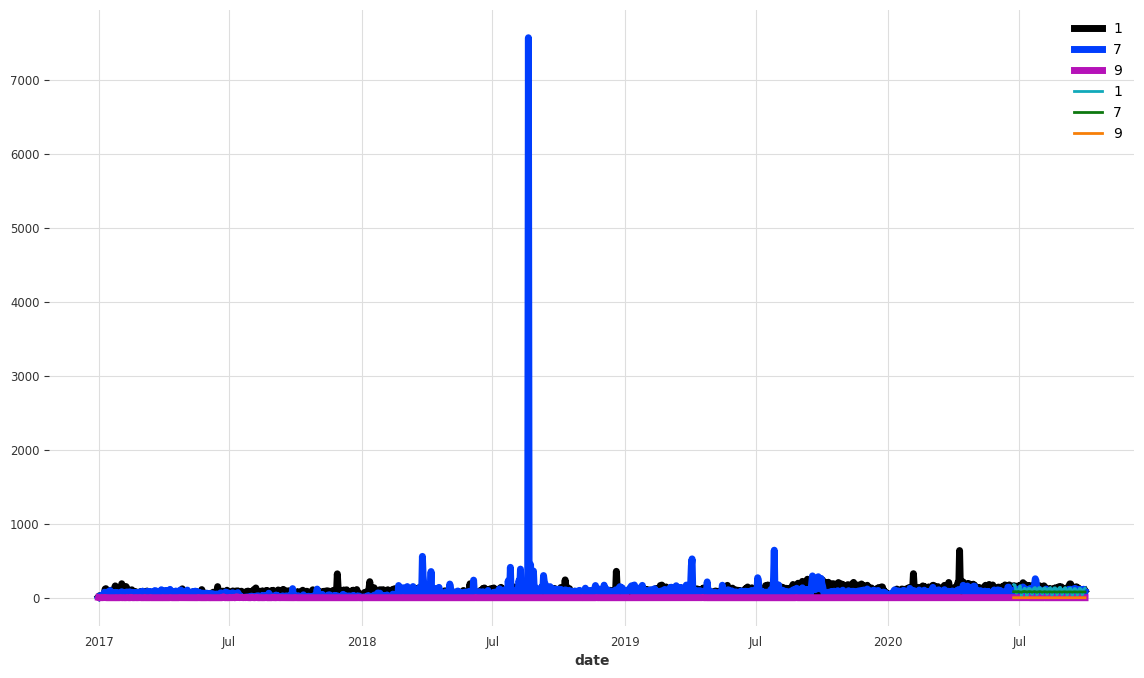

In [ ]:
plt.figure(figsize=(14, 8))
components_to_show = ["1", "7", "9"]
series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)

In [ ]:
def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        print(
            "mean MAE on {}: {:.2f}".format(
                name,
                mae(pred[subset], val[subset]),
            )
        )

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")

In [ ]:
measure_mae(pred)